# plot ekman pumping in easterlies experiment .. as a function of outcropping density class

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath
import datetime as dt
import xgcm

import xesmf
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:45285 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 8 Memory: 200.00 GiB


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [4]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

expt=control

In [5]:
variable='area_t'
area_t = cc.querying.getvar(expt,variable,master_session, n=-1)
area_t.load()
print(area_t.shape)

(2700, 3600)


In [6]:
# last 5 years of simulation:
start_time='2160-01-01'
end_time='2164-12-31'
#end_time='2150-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

# pick the northern latitude, so there are an equal number of t-cell and u-cell gridpoint in this range:
lat_slice  = slice(-82,-60.0) #-50.04-
    
#do global
lon_slice  = slice(-280, 80)

In [ ]:
#official 1000m isobath line
iso1=np.load('/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_1000m.npz'

In [7]:
# topography data for plotting:
ht = cc.querying.getvar(expt,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

In [8]:
#mask shelf regions
cstmask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>300)))
cstmask = cstmask.where(~xr.ufuncs.isfinite(cstmask.where(ht.yt_ocean>-63)))
cstmask = ~xr.ufuncs.isnan(cstmask).to_dataset(name='cstmask')
cstarea=area_t.where(cstmask.cstmask).sum(dim=('xt_ocean','yt_ocean')).compute()


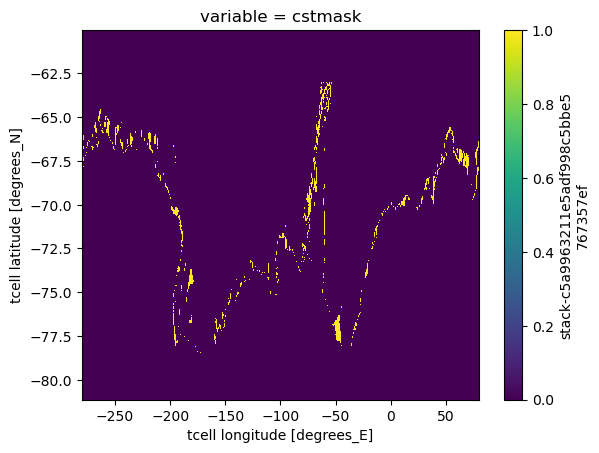

In [9]:
z=cstmask.to_array()
z.plot()

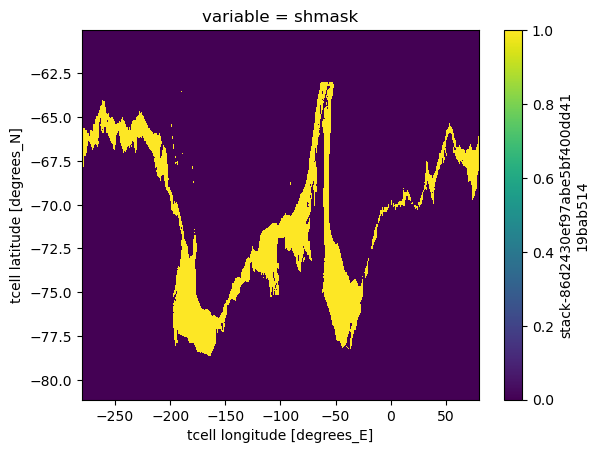

In [10]:
#mask shelf regions
shmask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>1000)))
shmask = shmask.where(~xr.ufuncs.isfinite(shmask.where(ht.yt_ocean>-63)))
shmask = ~xr.ufuncs.isnan(shmask).to_dataset(name='shmask')
sharea=area_t.where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()

z=shmask.to_array()
z.plot()

In [11]:
# Mistake, -1 is not needed for Ekman, but for SWMT
ekman_con=xr.open_dataset('ekmanpump_control_sigma0_2150-2164.nc').sel(year=slice(2160,2164)).mean(dim='year')*-1
ekman_up=xr.open_dataset('ekmanpump_up_sigma0_2150-2164.nc').sel(year=slice(2160,2164)).mean(dim='year')*-1
ekman_down=xr.open_dataset('ekmanpump_down_sigma0_2150-2164.nc').sel(year=slice(2160,2164)).mean(dim='year')*-1

ekman_upz=xr.open_dataset('ekmanpump_upz_sigma0_2150-2164.nc').sel(year=slice(2154,2157)).mean(dim='year')*-1
ekman_upm=xr.open_dataset('ekmanpump_upm_sigma0_2150-2164.nc').sel(year=slice(2154,2157)).mean(dim='year')*-1
ekman_upm

<xarray.Dataset>
Dimensions:         (isopycnal_bins: 51, xt_ocean: 3600, yt_ocean: 490)
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 24.05 24.15 24.25 ... 28.95 29.05
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.1 -60.05
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
Data variables:
    ekman_sigma0    (isopycnal_bins, yt_ocean, xt_ocean) float64 nan nan ... nan

# area integrate per rho class

In [12]:
ekman_con_aint=(ekman_con.ekman_sigma0*area_t).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_up_aint=(ekman_up.ekman_sigma0*area_t).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_upz_aint=(ekman_upz.ekman_sigma0*area_t).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_upm_aint=(ekman_upm.ekman_sigma0*area_t).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_down_aint=(ekman_down.ekman_sigma0*area_t).sum(dim=('xt_ocean','yt_ocean')).compute()

In [25]:
#ekman_con_coast_aint=(ekman_control.ekman_sigma0.mean(dim='year')*area_t).where(cstmask.cstmask).sum(dim=('xt_ocean','yt_ocean')).compute()
#ekman_up_coast_aint=(ekman_up.ekman_sigma0.mean(dim='year')*area_t).where(cstmask.cstmask).sum(dim=('xt_ocean','yt_ocean')).compute()
#ekman_down_coast_aint=(ekman_down.ekman_sigma0.mean(dim='year')*area_t).where(cstmask.cstmask).sum(dim=('xt_ocean','yt_ocean')).compute()

In [26]:
ekman_con_shelf_aint=(ekman_con.ekman_sigma0*area_t).where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_up_shelf_aint=(ekman_up.ekman_sigma0*area_t).where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_upz_shelf_aint=(ekman_upz.ekman_sigma0*area_t).where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_upm_shelf_aint=(ekman_upm.ekman_sigma0*area_t).where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_down_shelf_aint=(ekman_down.ekman_sigma0*area_t).where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()

In [27]:
ekman_up_aint

<xarray.DataArray (isopycnal_bins: 51)>
array([-1.98068663e+10, -2.06214629e+10, -2.72407192e+10, -3.25652214e+10,
       -3.89721561e+10, -4.63829496e+10, -5.43159500e+10, -5.54492236e+10,
       -6.15174723e+10, -7.17396789e+10, -7.02593963e+10, -8.18435384e+10,
       -8.58559598e+10, -9.80895816e+10, -1.07447694e+11, -1.00004576e+11,
       -1.08549609e+11, -1.18256547e+11, -1.06217830e+11, -8.25499302e+10,
       -5.58300351e+10, -1.74358730e+10,  1.98282084e+10,  4.18586916e+10,
        3.52791324e+10,  2.89488208e+10,  1.27686949e+11,  2.87147479e+11,
        6.31480938e+11,  1.37224109e+12,  1.82294782e+12,  2.26280922e+12,
        2.63013564e+12,  2.53485089e+12,  1.76360855e+12,  1.36732720e+12,
        1.07775557e+12, -6.41558517e+10, -7.15149111e+11, -3.57863041e+11,
       -2.21319146e+11, -7.00295247e+10, -2.16880392e+10, -6.28482533e+09,
       -9.18184931e+09, -3.54037743e+09, -1.47717787e+09, -5.86461464e+08,
        2.96030218e+09,  6.79491762e+08, -3.50952404e+08])
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 24.05 24.15 24.25 ... 28.95 29.05

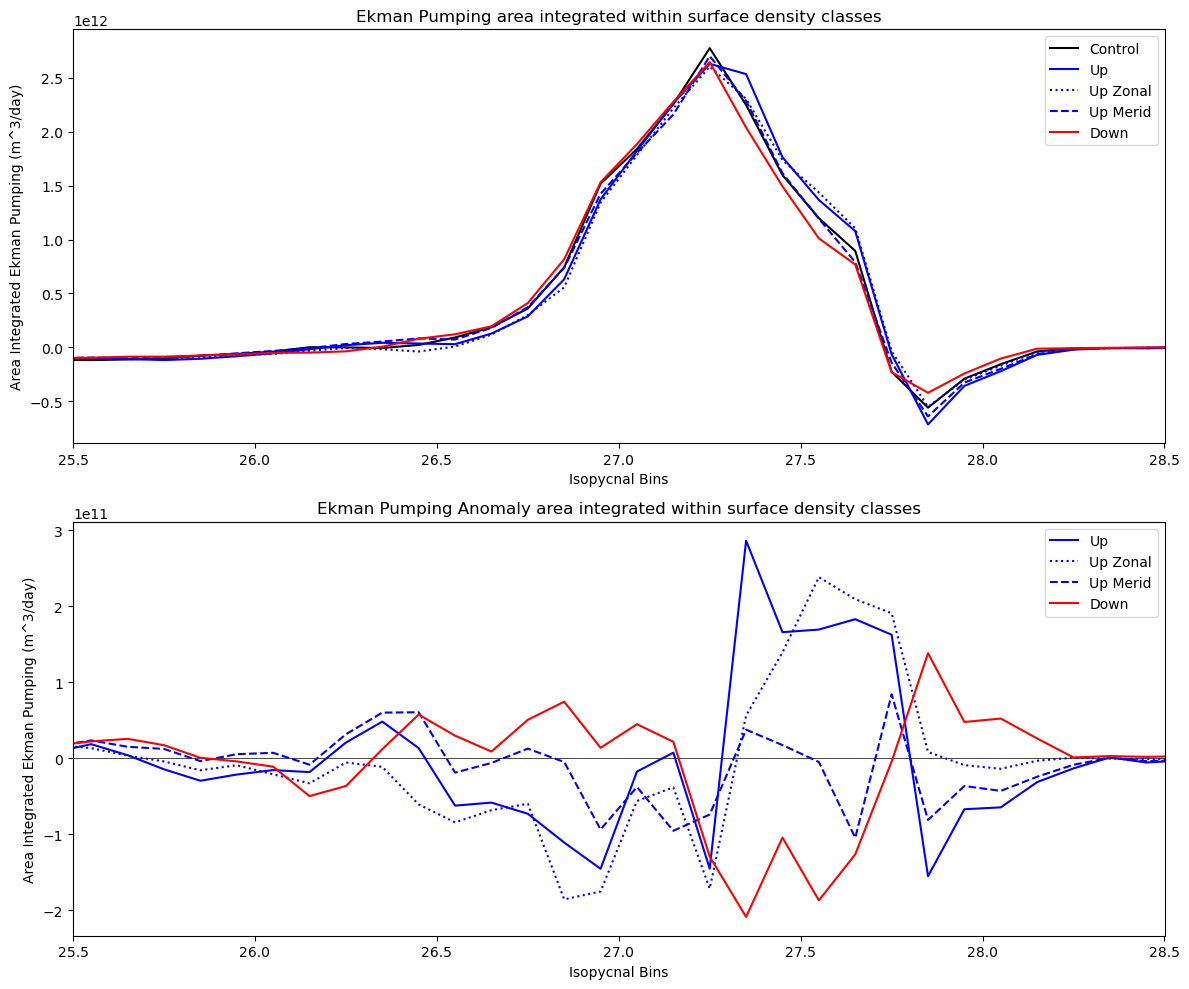

In [28]:
fontsize=12

plt.figure(figsize=(12,10))

plt.subplot(211)
plt.plot(ekman_con.isopycnal_bins,ekman_con_aint,linestyle='-',color='k',label='Control',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_up_aint,linestyle='-',color='b',label='Up',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upz_aint,linestyle=':',color='b',label='Up Zonal',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upm_aint,linestyle='--',color='b',label='Up Merid',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_down_aint,linestyle='-',color='r',label='Down',linewidth=1.5)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
plt.ylabel('Area Integrated Ekman Pumping (m^3/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Ekman Pumping area integrated within surface density classes')
plt.legend(fontsize=10)

plt.subplot(212)
plt.plot(ekman_con.isopycnal_bins,ekman_con_aint-ekman_con_aint,linestyle='-',color='k',linewidth=0.5)
plt.plot(ekman_con.isopycnal_bins,ekman_up_aint-ekman_con_aint,linestyle='-',color='b',label='Up',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upz_aint-ekman_con_aint,linestyle=':',color='b',label='Up Zonal',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upm_aint-ekman_con_aint,linestyle='--',color='b',label='Up Merid',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_down_aint-ekman_con_aint,linestyle='-',color='r',label='Down',linewidth=1.5)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
plt.ylabel('Area Integrated Ekman Pumping (m^3/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Ekman Pumping Anomaly area integrated within surface density classes')
plt.legend(fontsize=10)

plt.tight_layout()

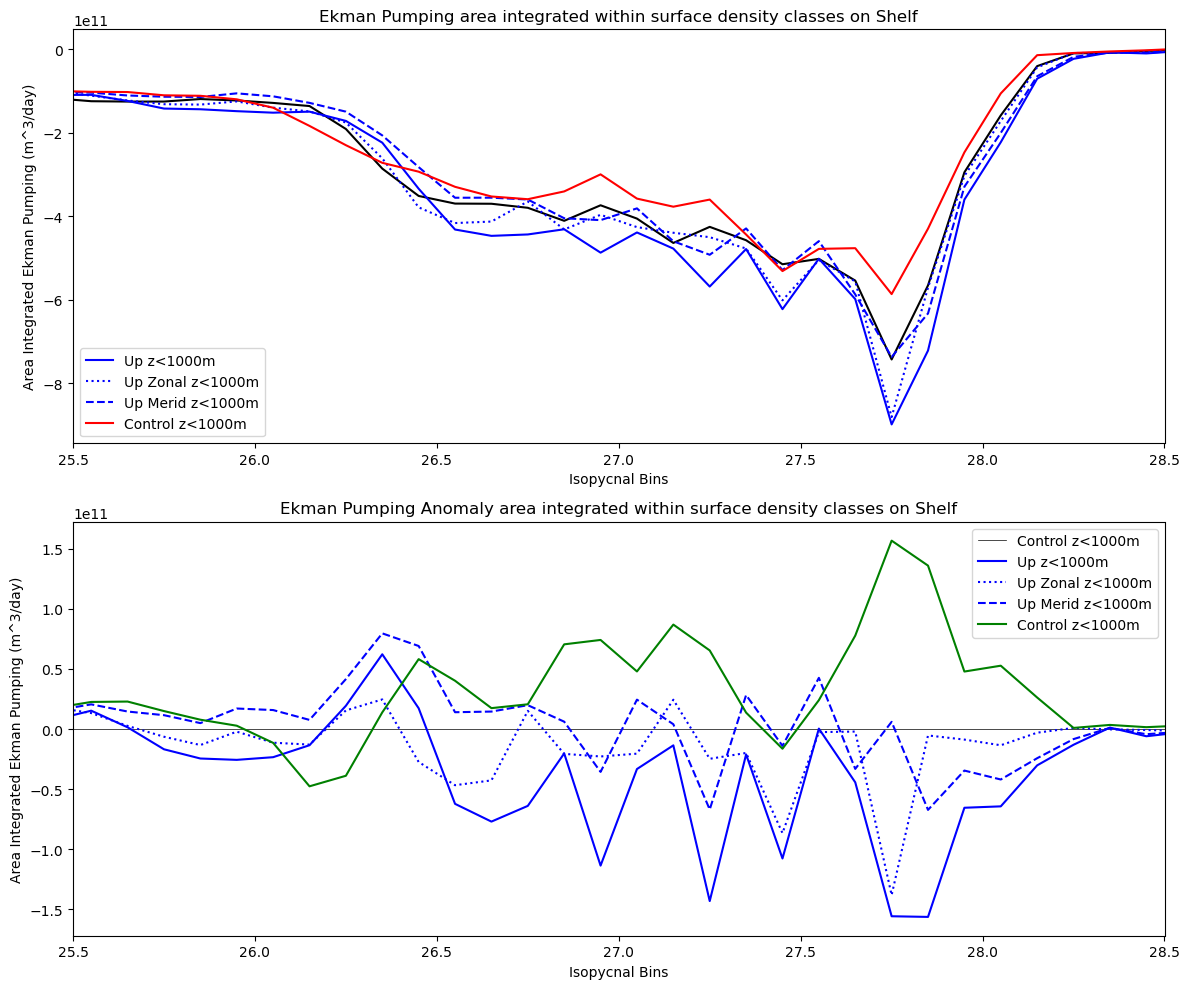

In [29]:
fontsize=12

plt.figure(figsize=(12,10))

plt.subplot(211)
plt.plot(ekman_con.isopycnal_bins,ekman_con_shelf_aint,linestyle='-',color='k',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_up_shelf_aint,linestyle='-',color='b',label='Up z<1000m',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upz_shelf_aint,linestyle=':',color='b',label='Up Zonal z<1000m',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upm_shelf_aint,linestyle='--',color='b',label='Up Merid z<1000m',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_down_shelf_aint,linestyle='-',color='r',label='Control z<1000m',linewidth=1.5)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
plt.ylabel('Area Integrated Ekman Pumping (m^3/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Ekman Pumping area integrated within surface density classes on Shelf')
plt.legend(fontsize=10)

plt.subplot(212)
plt.plot(ekman_con.isopycnal_bins,ekman_con_shelf_aint-ekman_con_shelf_aint,linestyle='-',color='k',label='Control z<1000m',linewidth=0.5)
plt.plot(ekman_con.isopycnal_bins,ekman_up_shelf_aint-ekman_con_shelf_aint,linestyle='-',color='b',label='Up z<1000m',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upz_shelf_aint-ekman_con_shelf_aint,linestyle=':',color='b',label='Up Zonal z<1000m',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upm_shelf_aint-ekman_con_shelf_aint,linestyle='--',color='b',label='Up Merid z<1000m',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_down_shelf_aint-ekman_con_shelf_aint,linestyle='-',color='g',label='Control z<1000m',linewidth=1.5)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
plt.ylabel('Area Integrated Ekman Pumping (m^3/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Ekman Pumping Anomaly area integrated within surface density classes on Shelf')
plt.legend(fontsize=10)

plt.tight_layout()

## plot zonal average rho and temp to identify CDW classes

In [30]:
# Surface density:
pot_rho_0 = cc.querying.getvar(expt, 'pot_rho_0', master_session, ncfile='ocean.nc',start_time=start_time, end_time=end_time) - 1000
pot_rho_0 = pot_rho_0.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).mean(dim='time') #.resample({'time':'Y'}).mean('time')
pot_rho_0

<xarray.DataArray 'pot_rho_0' (st_ocean: 75, yt_ocean: 490, xt_ocean: 3600)>
dask.array<mean_agg-aggregate, shape=(75, 490, 3600), dtype=float32, chunksize=(7, 300, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

In [57]:
temp = cc.querying.getvar(expt, 'temp', master_session, ncfile='ocean.nc',start_time=start_time, end_time=end_time) -273.13
temp = temp.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).mean(dim='time') #.resample({'time':'Y'}).mean('time')
temp

<xarray.DataArray 'temp' (st_ocean: 75, yt_ocean: 490, xt_ocean: 3600)>
dask.array<mean_agg-aggregate, shape=(75, 490, 3600), dtype=float32, chunksize=(7, 300, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

In [42]:
#needed for contour labels
rho=pot_rho_0.mean(dim='xt_ocean').compute()
rho

<xarray.DataArray 'pot_rho_0' (st_ocean: 75, yt_ocean: 490)>
array([[      nan,       nan,       nan, ..., 27.130367, 27.129353,
        27.12829 ],
       [      nan,       nan,       nan, ..., 27.130692, 27.129677,
        27.128622],
       [      nan,       nan,       nan, ..., 27.130941, 27.129927,
        27.128876],
       ...,
       [      nan,       nan,       nan, ..., 27.841833, 27.841797,
        27.841919],
       [      nan,       nan,       nan, ..., 27.841051, 27.84074 ,
        27.840538],
       [      nan,       nan,       nan, ..., 27.836014, 27.837002,
        27.837357]], dtype=float32)
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

In [58]:
t=temp.mean(dim='xt_ocean').compute()
t

<xarray.DataArray 'temp' (st_ocean: 75, yt_ocean: 490)>
array([[        nan,         nan,         nan, ...,  0.9459783 ,
         0.97160697,  0.9981834 ],
       [        nan,         nan,         nan, ...,  0.94655555,
         0.972158  ,  0.9986878 ],
       [        nan,         nan,         nan, ...,  0.94602716,
         0.97161824,  0.998125  ],
       ...,
       [        nan,         nan,         nan, ..., -0.49542972,
        -0.49958783, -0.49213472],
       [        nan,         nan,         nan, ..., -0.48861665,
        -0.50220805, -0.50026715],
       [        nan,         nan,         nan, ..., -0.56033736,
        -0.5546589 , -0.5526337 ]], dtype=float32)
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

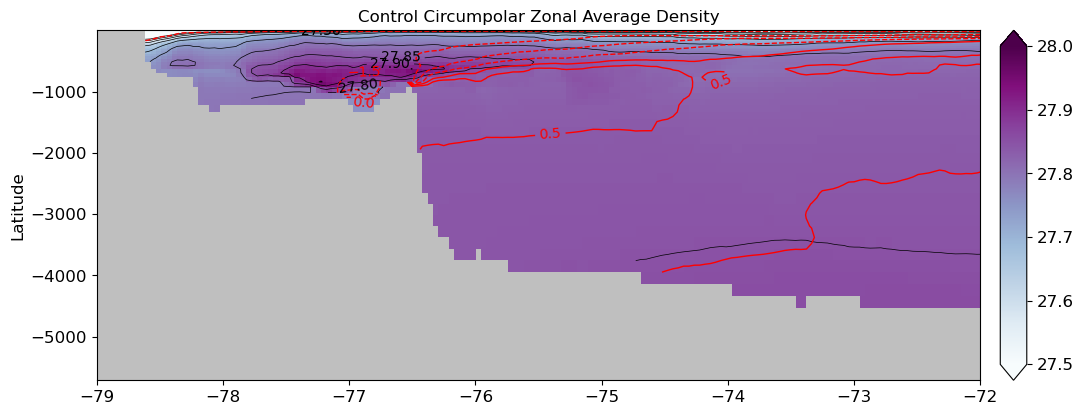

In [61]:
fontsize=12
levels=np.arange(27.5, 28., 0.05)
levels2=np.arange(-2, 6, 0.5)


plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.title('Control Circumpolar Zonal Average Density',fontsize=fontsize)
plt.gca().patch.set_color('.75')
plt.xlim(-79,-72)
#plt.xlim(-140,-100)

p1=plt.pcolormesh(rho.yt_ocean,-rho.st_ocean,rho,vmin=27.5,vmax=28.,cmap=plt.cm.BuPu)
pr=plt.contour(rho.yt_ocean,-rho.st_ocean,rho,levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)

pr2=plt.contour(t.yt_ocean,-t.st_ocean,t,levels=levels2,colors='r',linewidths=1)
plt.clabel(pr2, pr2.levels, inline=True,fontsize=10)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'both')
#cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

## plot area average ekmanpumping per rho bin

In [12]:
ekman_control_aavg=ekman_control.ekman_sigma0.mean(dim='year').weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()
ekman_up_aavg=ekman_up.ekman_sigma0.mean(dim='year').weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()
ekman_down_aavg=ekman_down.ekman_sigma0.mean(dim='year').weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()


In [13]:
ekman_control_coast_aavg=ekman_control.ekman_sigma0.mean(dim='year').where(cstmask.cstmask).weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()
ekman_up_coast_aavg=ekman_up.ekman_sigma0.mean(dim='year').where(cstmask.cstmask).weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()
ekman_down_coast_aavg=ekman_down.ekman_sigma0.mean(dim='year').where(cstmask.cstmask).weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()


In [14]:
ekman_control_shelf_aavg=ekman_control.ekman_sigma0.mean(dim='year').where(shmask.shmask).weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()
ekman_up_shelf_aavg=ekman_up.ekman_sigma0.mean(dim='year').where(shmask.shmask).weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()
ekman_down_shelf_aavg=ekman_down.ekman_sigma0.mean(dim='year').where(shmask.shmask).weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()


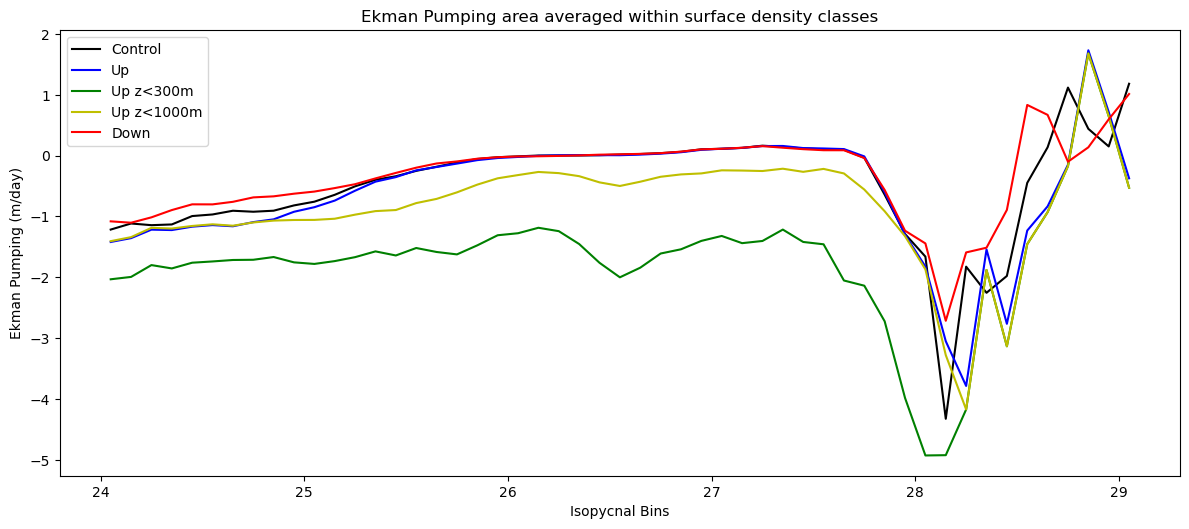

In [15]:
fontsize=12
levels=np.arange(24., 29., 0.5)


plt.figure(figsize=(12,10))

#needed for contour labels
var=pot_rho_0[0].sel(xt_ocean=slice(-150,-90))

plt.subplot(2,1,1)
plt.title('Control Surface Density Amundsen/Bellingshausen Jan',fontsize=fontsize)
plt.gca().patch.set_color('.75')
plt.ylim(-75.5,-71)
plt.xlim(-140,-100)
p1=plt.pcolormesh(var.xt_ocean,var.yt_ocean,var,vmin=isopycnal_bins[0],vmax=isopycnal_bins[-1],cmap=plt.cm.BuPu)
pr=plt.contour(var.xt_ocean,var.yt_ocean,var,levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'both')
#cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
